# Gradio Example <a name="XAITK-Saliency-Gradio-Example"></a>
This notebook makes use of the saliency generation example found in the base ``xaitk-saliency`` repo [here](https://github.com/XAITK/xaitk-saliency/blob/master/examples/OcclusionSaliency.ipynb), and explores integrating ``xaitk-saliency`` with ``Gradio`` to create an interactive interface for computing saliency maps.

## Set Up Environment <a name="Set-Up-Environment-Gradio"></a>

In [ ]:
import sys
!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency
!{sys.executable} -m pip install -q torch
!{sys.executable} -m pip install -q torchvision
!{sys.executable} -m pip install -q gradio

## Test Image <a name="Test-Image-Gradio"></a>

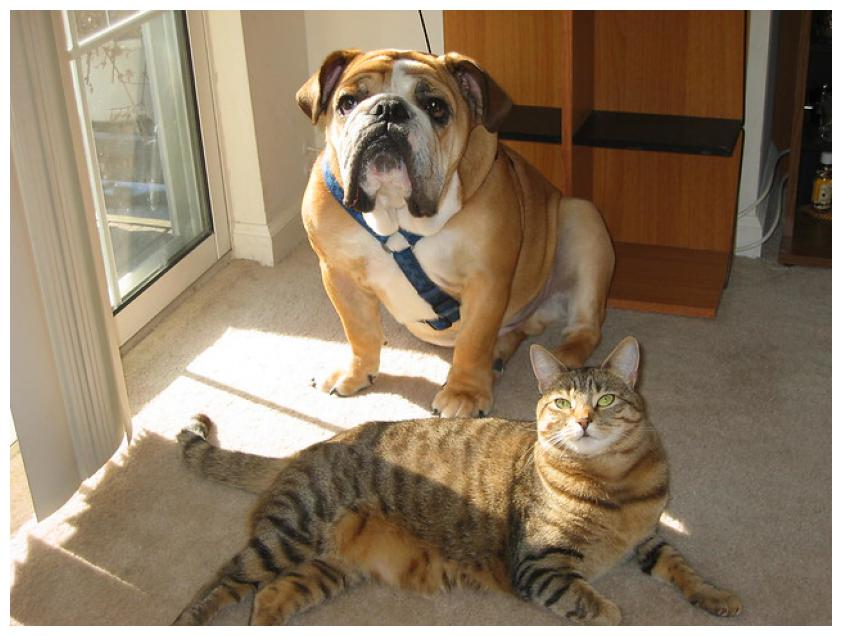

In [1]:
import os
import PIL.Image
import matplotlib.pyplot as plt  # type: ignore
import urllib.request

# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"

os.makedirs('data', exist_ok=True)
test_image_filename = 'data/catdog.jpg'
urllib.request.urlretrieve('https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg', test_image_filename)
plt.figure(figsize=(12, 8))
plt.axis('off')
_ = plt.imshow(PIL.Image.open(test_image_filename))

## Initialize state variables for Gradio components <a name="Global-State-Gradio"></a>
Gradio expects either a list or dict format to maintain state variables based on the use case. The cell below initializes the state variables from the ``gr_component_state.py`` file for the various components in our gradio demo.

In [2]:
# State variables for Image Classification
from gr_component_state import ( # type: ignore
    img_cls_model_name, img_cls_saliency_algo_name, window_size_state, stride_state, debiased_state,
)

# State functions for Image Classification
from gr_component_state import ( # type: ignore
    select_img_cls_model, select_img_cls_saliency_algo, enter_window_size, enter_stride, check_debiased
)

# State variables for Object Detection
from gr_component_state import ( # type: ignore
    obj_det_model_name, obj_det_saliency_algo_name, occlusion_grid_state
)

# State functions for Object Detection
from gr_component_state import ( # type: ignore
    select_obj_det_model, select_obj_det_saliency_algo, enter_occlusion_grid_size
)

# Common state variables
from gr_component_state import ( # type: ignore
    threads_state, num_masks_state, spatial_res_state, p1_state, seed_state
)

# Common state functions
from gr_component_state import ( # type: ignore
    select_threads, enter_num_masks, enter_spatial_res, select_p1, enter_seed
)

## Helper Functions <a name="Helper-Functions-Gradio"></a>
The functions defined in the cell below are used to set up the model, saliency algorithm, class labels and image transforms needed for the demo.

In [3]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import urllib
from smqtk_detection.impls.detect_image_objects.centernet import CenterNetVisdrone
from smqtk_detection.impls.detect_image_objects.resnet_frcnn import ResNetFRCNN
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.rise import RISEStack
from xaitk_saliency.impls.gen_object_detector_blackbox_sal.drise import RandomGridStack, DRISEStack


CUDA_AVAILABLE = torch.cuda.is_available()

model_input_size = (224, 224)
model_mean = [0.485, 0.456, 0.406]
model_loader = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(model_input_size), 
    transforms.ToTensor(),
    transforms.Normalize(
        mean=model_mean,
        std=[0.229, 0.224, 0.225]
    ),
])

def get_sal_labels(classes_file, custom_categories_list=None):
    if not os.path.isfile(classes_file):
        url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        _ = urllib.request.urlretrieve(url, classes_file)
    
    f = open(classes_file, "r")
    categories = [s.strip() for s in f.readlines()]
    
    if not custom_categories_list == None:
        sal_class_labels = custom_categories_list
    else:
        sal_class_labels = categories
    
    sal_class_idxs = [categories.index(lbl) for lbl in sal_class_labels]
    
    return sal_class_labels, sal_class_idxs

def get_det_sal_labels(classes_file, custom_categories_list=None):
    if not os.path.isfile(classes_file):
        url = "https://raw.githubusercontent.com/matlab-deep-learning/Object-Detection-Using-Pretrained-YOLO-v2/main/%2Bhelper/coco-classes.txt"
        _ = urllib.request.urlretrieve(url, classes_file)
    
    f = open(classes_file, "r")
    categories = [s.strip() for s in f.readlines()]
    
    if not custom_categories_list == None:
        sal_obj_labels = custom_categories_list
    else:
        sal_obj_labels = categories
    
    sal_obj_idxs = [categories.index(lbl) for lbl in sal_obj_labels]

    return sal_obj_labels, sal_obj_idxs

def get_model(model_choice):
    if model_choice == "ResNet-18":
        model = models.resnet18(pretrained=True)
    else:
        model = models.resnet50(pretrained=True)
    model = model.eval()
    if CUDA_AVAILABLE:
        model = model.cuda()

    return model

def get_detection_model(model_choice):

    if model_choice == "Faster-RCNN":
        blackbox_detector = ResNetFRCNN(
            box_thresh=0.05,
            img_batch_size=1,
            use_cuda=True
        )
    
    else:
        raise Exception("Unknown Input")

    return blackbox_detector

def get_saliency_algo(sal_choice):
    if sal_choice == "RISE":
        gen_sal = RISEStack(
            n=num_masks_state[-1], 
            s=spatial_res_state[-1], 
            p1=p1_state[-1], 
            seed=seed_state[-1], 
            threads=threads_state[-1], 
            debiased=debiased_state[-1]
        )
        
    elif sal_choice == "SlidingWindowStack":
        gen_sal = SlidingWindowStack(
            window_size=eval(window_size_state[-1]),
            stride=eval(stride_state[-1]),
            threads=threads_state[-1]
        )
    
    else:
        raise Exception("Unknown Input")

    return gen_sal

def get_detection_saliency_algo(sal_choice):
    if sal_choice == "RandomGridStack":
        gen_sal = RandomGridStack(
            n=num_masks_state[-1],
            s=eval(occlusion_grid_state[-1]),
            p1=p1_state[-1],
            threads=threads_state[-1],  
            seed=seed_state[-1],  
        )
    
    elif sal_choice == "DRISE":
        gen_sal = DRISEStack(
            n=num_masks_state[-1], 
            s=spatial_res_state[-1], 
            p1=p1_state[-1], 
            seed=seed_state[-1], 
            threads=threads_state[-1]
        )
    
    else:
        raise Exception("Unknown Input")
    
    return gen_sal

In [4]:
import torch.nn.functional
from smqtk_classifier.interfaces.classify_image import ClassifyImage
import numpy as np

data_path = "./data"
if not os.path.exists(data_path):
    os.makedirs(data_path)

# Setup imagenet classes and ClassifyImage for generating classification saliency

classes_file = os.path.join(data_path,"imagenet_classes.txt")
sal_class_labels, sal_class_idxs = get_sal_labels(classes_file)

class TorchResnet (ClassifyImage):

    modified_class_labels = []

    def get_labels(self):
        return self.modified_class_labels
    
    def set_labels(self, class_labels):
        self.modified_class_labels = [lbl for lbl in class_labels]
    
    @torch.no_grad()
    def classify_images(self, image_iter):
        # Input may either be an NDaray, or some arbitrary iterable of NDarray images.
        
        model = get_model(img_cls_model_name[-1])
        
        for img in image_iter:
            image_tensor = model_loader(img).unsqueeze(0)
            if CUDA_AVAILABLE:
                image_tensor = image_tensor.cuda()
            
            feature_vec = model(image_tensor)
            # Converting feature extractor output to probabilities.
            class_conf = torch.nn.functional.softmax(feature_vec, dim=1).cpu().detach().numpy().squeeze()
            # Only return the confidences for the focus classes
            yield dict(zip(sal_class_labels, class_conf[sal_class_idxs]))
            
    def get_config(self):
        # Required by a parent class.
        return {}

blackbox_classifier, blackbox_fill = TorchResnet(), np.uint8(np.asarray(model_mean) * 255).tolist()

# Setup COCO object classes for generating detection saliency

obj_classes_file = os.path.join(data_path,"coco_classes.txt")
sal_obj_labels, sal_obj_idxs = get_det_sal_labels(obj_classes_file)

In [5]:
import numpy as np
from gradio import (  # type: ignore
    Checkbox, Dropdown, SelectData, Slider, Textbox  # type: ignore
)
from gradio import processing_utils as gr_processing_utils  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
from xaitk_saliency.interfaces.gen_object_detector_blackbox_sal import GenerateObjectDetectorBlackboxSaliency
from smqtk_detection.interfaces.detect_image_objects import DetectImageObjects

# Modify textbox parameters based on chosen saliency algorithm
def show_textbox_parameters(choice):
    if choice == 'RISE':
        return Textbox.update(visible=False), Textbox.update(visible=False), Textbox.update(visible=True), Textbox.update(visible=True), Textbox.update(visible=True)
    elif choice == 'SlidingWindowStack':
        return Textbox.update(visible=True), Textbox.update(visible=True), Textbox.update(visible=False), Textbox.update(visible=False), Textbox.update(visible=False)
    elif choice == "RandomGridStack":
        return Textbox.update(visible=True), Textbox.update(visible=False), Textbox.update(visible=True), Textbox.update(visible=True)
    elif choice == "DRISE":
        return Textbox.update(visible=True), Textbox.update(visible=True), Textbox.update(visible=True), Textbox.update(visible=False)
    else:
        raise Exception("Unknown Input")

# Modify slider parameters based on chosen saliency algorithm
def show_slider_parameters(choice):
    if choice == 'RISE' or choice == 'RandomGridStack' or choice == 'DRISE':
        return Slider.update(visible=True), Slider.update(visible=True)
    elif choice == 'SlidingWindowStack':
        return Slider.update(visible=True), Slider.update(visible=False)
    else:
        raise Exception("Unknown Input")
    
# Modify checkbox parameters based on chosen saliency algorithm
def show_debiased_checkbox(choice):
    if choice == 'RISE':
        return Checkbox.update(visible=True)
    elif choice == 'SlidingWindowStack' or choice == 'RandomGridStack' or choice == 'DRISE':
        return Checkbox.update(visible=False)
    else:
        raise Exception("Unknown Input")

# Function that is called after clicking the "Classify" button in the demo
def predict(x,top_n_classes):
    
    image_tensor = model_loader(x).unsqueeze(0)
    if CUDA_AVAILABLE:
        image_tensor = image_tensor.cuda()
    model = get_model(img_cls_model_name[-1])
    feature_vec = model(image_tensor)
    class_conf = torch.nn.functional.softmax(feature_vec, dim=1).cpu().detach().numpy().squeeze()
    labels = list(zip(sal_class_labels, class_conf[sal_class_idxs].tolist()))
    final_labels = dict(sorted(labels, key=lambda t: t[1],reverse=True)[:top_n_classes])
    
    return final_labels, Dropdown.update(choices=list(final_labels))

# Interpretation function for image classification that implements the selected saliency algorithm and generates the class-wise saliency map visualizations
def interpretation_function(image: np.ndarray, 
                        labels: dict,
                        nth_class: str, 
                        img_alpha,
                        sal_alpha,
                        sal_range_min,
                        sal_range_max):
    
    sal_generator = get_saliency_algo(img_cls_saliency_algo_name[-1])
    sal_generator.fill = blackbox_fill
    labels_list = [i['label'] for i in labels['confidences']]
    blackbox_classifier.set_labels(labels_list)
    sal_maps = sal_generator(image, blackbox_classifier)
    nth_class_index = blackbox_classifier.get_labels().index(nth_class)
    scores = sal_maps[nth_class_index,:,:]
    fig = visualize_saliency_plot(image,
                                sal_maps[nth_class_index,:,:],
                                img_alpha,
                                sal_alpha,
                                sal_range_min,
                                sal_range_max)
    
    scores = np.clip(scores, sal_range_min, sal_range_max)
        
    return {"original": gr_processing_utils.encode_array_to_base64(image), 
            "interpretation": scores.tolist()}, fig

def visualize_saliency_plot(image: np.ndarray, 
                            class_sal_map: np.ndarray,
                            img_alpha,
                            sal_alpha,
                            sal_range_min,
                            sal_range_max):
    colorbar_kwargs = {
        "fraction": 0.046*(image.shape[0]/image.shape[1]),
        "pad": 0.04,
    }
    fig = plt.figure()
    plt.imshow(image, alpha=img_alpha)
    plt.imshow(
        np.clip(class_sal_map, sal_range_min, sal_range_max),
        cmap='jet', alpha=sal_alpha
    )
    plt.clim(sal_range_min, sal_range_max)
    plt.colorbar(**colorbar_kwargs)
    plt.title(f"Saliency Map")
    plt.axis('off')
    plt.close(fig)

    return fig

# Generate top-n object detect predictions on the input image
def run_detect(input_img: np.ndarray, num_detections: int):
    detect_model = get_detection_model(obj_det_model_name[-1])
    preds = list(list(detect_model([input_img]))[0])
    n_preds = len(preds)
    n_classes = len(preds[0][1])

    bboxes = np.empty((n_preds, 4), dtype=np.float32)
    scores = np.empty((n_preds, n_classes), dtype=np.float32)
    max_scores_index = np.empty((n_preds, 1), dtype=int)
    labels = None
    final_bbox = []
    final_label = []
    for i, (bbox, score_dict) in enumerate(preds):
        bboxes[i] = (*bbox.min_vertex, *bbox.max_vertex)
        score_list = list(score_dict.values())
        scores[i] = score_list
        max_scores_index[i] = score_list.index(max(score_list))
        if labels is None:
            labels = list(score_dict.keys())
        label_name = str(labels[int(max_scores_index[i,0])])
        conf_score = str(round(score_list[int(max_scores_index[i,0])],4))
        label_with_score = str(i) + " : "+ label_name + " - " + conf_score
        final_label.append(label_with_score)
    
    bboxes_list = bboxes[:,:].astype(int).tolist()

    return (input_img, list(zip([f for f in bboxes_list], [l for l in final_label]))[:num_detections]), Dropdown.update(choices=[l for l in final_label][:num_detections])

# Run saliency algorithm on the object detect predictions and generate corresponding visualizations
def run_detect_saliency(input_img: np.ndarray, 
                        num_predictions,
                        obj_label, 
                        img_alpha,
                        sal_alpha,
                        sal_range_min,
                        sal_range_max):
    
    detect_model = get_detection_model(obj_det_model_name[-1])
    img_preds = list(list(detect_model([input_img]))[0])
    ref_preds = img_preds[:int(num_predictions)]
    ref_bboxes = []
    ref_scores = []
    for det in ref_preds:
        bbox = det[0]
        ref_bboxes.append([
            *bbox.min_vertex,
            *bbox.max_vertex,
        ])

        score_dict = det[1]
        ref_scores.append(list(score_dict.values()))

    ref_bboxes = np.array(ref_bboxes)
    ref_scores = np.array(ref_scores)
    
    print(f"Ref bboxes: {ref_bboxes.shape}")
    print(f"Ref scores: {ref_scores.shape}")
    
    sal_generator = get_detection_saliency_algo(obj_det_saliency_algo_name[-1])
    sal_generator.fill = blackbox_fill
    
    sal_maps = gen_det_saliency(input_img, detect_model, sal_generator,ref_bboxes,ref_scores)
    print(f"Saliency maps: {sal_maps.shape}")

    nth_class_index = int(obj_label.split(' : ')[0])
    scores = sal_maps[nth_class_index,:,:]
    fig = visualize_saliency_plot(input_img,
                                sal_maps[nth_class_index,:,:],
                                img_alpha,
                                sal_alpha,
                                sal_range_min,
                                sal_range_max)
    
    scores = np.clip(scores, sal_range_min, sal_range_max)

    return fig

def gen_det_saliency(input_img: np.ndarray,
    blackbox_detector: DetectImageObjects,
    sal_map_generator: GenerateObjectDetectorBlackboxSaliency,
    ref_bboxes: np.ndarray,
    ref_scores: np.ndarray
):
    sal_maps = sal_map_generator.generate(
        input_img,
        ref_bboxes,
        ref_scores,
        blackbox_detector,
    )

    return sal_maps

# Event handler that populates the dropdown list of classes based on the Label/AnnotatedImage components' output
def map_labels(evt: SelectData):

    return str(evt.value)

## Gradio Demo using Python Script <a name="Python-Script-Demo-Gradio"></a>

After setting up the methods and variables defined across the cells prior to this point, the layout and components for our example can be defined under ``gr.Blocks()`` as follows: (Note: Please refer to [Setup Blocks](#setup-blocks) for defining the layout and components for our current example.)

```
import gradio as gr

with gr.Blocks() as demo:
    ....
    Define layout and components
    ....

if __name__ == '__main__'
    demo.launch()
```

After setting up the python script (assuming the name of the script is ``xaitk_gradio.py``), open a terminal, activate the required python venv and run the following command:

```python xaitk_gradio.py```

As an alternative, the code can be run in ``reload mode`` by replacing ``python`` with ``gradio`` in the command:

```gradio xaitk_gradio.py```


## Gradio Demo using Jupyter Notebook <a name="Jupyter-Notebook-Demo-Gradio"></a>

### Load Gradio Extension <a name="Load-Extension-Gradio"></a>

The ``magic command`` below loads the gradio extension which is needed to run a Gradio ``Blocks`` demo.

In [6]:
%load_ext gradio

### Setup Blocks <a name="Setup-Blocks-Gradio"></a>

In order to execute a gradio application within a Jupyter Notebook, the ``%%blocks`` command is used. This replaces the ``with gr.Blocks() as demo:`` codeblock and the ``demo.launch()`` code from a regular python script.

In [7]:
%%blocks 

from gradio import (  # type: ignore
    AnnotatedImage, Button, Column, Image, Label, # type: ignore
    Number, Plot, Row, TabItem, Tab, Tabs # type: ignore
)
from gradio import components as gr_components  # type: ignore

with Tab("Image Classification"):
    with Row():
        with Column(scale=0.5):
            drop_list = Dropdown(value=img_cls_model_name[-1],choices=["ResNet-18","ResNet-50"],label="Choose Model",interactive="True")
        with Column(scale=0.5):
            drop_list_sal = Dropdown(value=img_cls_saliency_algo_name[-1],choices=["SlidingWindowStack","RISE"],label="Choose Saliency Algorithm",interactive="True")
    with Row():
        with Column(scale=0.33):
            window_size = Textbox(value=window_size_state[-1],label="Tuple of window size values (Press Enter to submit the input)",interactive=True,visible=False)
            masks = Number(value=num_masks_state[-1],label="Number of Random Masks (Press Enter to submit the input)",interactive=True,visible=False,precision=0)
        with Column(scale=0.33):
            stride = Textbox(value=stride_state[-1],label="Tuple of stride values (Press Enter to submit the input)" ,interactive=True,visible=False)
            spatial_res = Number(value=spatial_res_state[-1],label="Spatial Resolution of Masking Grid (Press Enter to submit the input)" ,interactive=True,visible=False,precision=0)
        with Column(scale=0.33):
            threads = Slider(value=threads_state[-1],label="Threads",interactive=True,visible=False)
    with Row():
        with Column(scale=0.33):
            seed = Number(value=seed_state[-1],label="Seed (Press Enter to submit the input)",interactive=True,visible=False,precision=0)
        with Column(scale=0.33):
            p1 = Slider(value=p1_state[-1],label="P1",interactive=True,visible=False, minimum=0,maximum=1,step=0.1)
        with Column(scale=0.33):
            debiased = Checkbox(value=debiased_state[-1],label="Debiased", interactive=True, visible=False)
    with Row():
        with Column():
            input_img = Image(label="Saliency Map Generation", shape=(640, 480))
            num_classes = Slider(value=2,label="Top-N class labels", interactive=True,visible=True)
            classify = Button("Classify")
        with Column():
            class_label = Label(label="Predicted Class")
        with Column():
            with Row():
                class_name = Dropdown(label="Class to compute saliency",interactive=True,visible=True)
            with Row():
                img_alpha = Slider(value=0.7,label="Image Opacity",interactive=True,visible=True,minimum=0,maximum=1,step=0.1)
                sal_alpha = Slider(value=0.3,label="Saliency Map Opacity",interactive=True,visible=True,minimum=0,maximum=1,step=0.1)
            with Row():
                min_sal_range = Slider(value=0,label="Minimum Saliency Value",interactive=True,visible=True,minimum=-1,maximum=1,step=0.05)
                max_sal_range = Slider(value=1,label="Maximum Saliency Value",interactive=True,visible=True,minimum=-1,maximum=1,step=0.05)
            with Row():
                generate_saliency = Button("Generate Saliency")
        with Column():
            with Tabs():
                with TabItem("Display interpretation with plot"):
                    interpretation_plot = Plot()
                with TabItem("Display interpretation with built-in component"):
                    interpretation = gr_components.Interpretation(input_img)

with Tab("Object Detection"):
    with Row():
        with Column(scale=0.5):
            drop_list_detect_model = Dropdown(value=obj_det_model_name[-1],choices=["Faster-RCNN"],label="Choose Model",interactive="True")
        with Column(scale=0.5):
            drop_list_detect_sal = Dropdown(value=obj_det_saliency_algo_name[-1],choices=["RandomGridStack","DRISE"],label="Choose Saliency Algorithm",interactive="True")
    with Row():
        with Column(scale=0.33):
            masks_detect = Number(value=num_masks_state[-1],label="Number of Random Masks (Press Enter to submit the input)",interactive=True,visible=False,precision=0)
            occlusion_grid_size = Textbox(value=occlusion_grid_state[-1],label="Tuple of occlusion grid size values (Press Enter to submit the input)",interactive=True,visible=False)
            spatial_res_detect = Number(value=spatial_res_state[-1],label="Spatial Resolution of Masking Grid (Press Enter to submit the input)" ,interactive=True,visible=False,precision=0)
        with Column(scale=0.33):
            seed_detect = Number(value=seed_state[-1],label="Seed (Press Enter to submit the input)",interactive=True,visible=False,precision=0)
            p1_detect = Slider(value=p1_state[-1],label="P1",interactive=True,visible=False, minimum=0,maximum=1,step=0.1)
        with Column(scale=0.33):
            threads_detect = Slider(value=threads_state[-1],label="Threads",interactive=True,visible=False)
    with Row():
        with Column():
            input_img_detect = Image(label="Saliency Map Generation", shape=(640, 480))
            num_detections = Slider(value=2,label="Top-N detections", interactive=True,visible=True)
            detection = Button("Run Detection Algorithm")
        with Column():
            detect_label = AnnotatedImage(label="Detections")
        with Column():
            with Row():
                class_name_det = Dropdown(label="Detection to compute saliency",interactive=True,visible=True)
            with Row():
                img_alpha_det = Slider(value=0.7,label="Image Opacity",interactive=True,visible=True,minimum=0,maximum=1,step=0.1)
                sal_alpha_det = Slider(value=0.3,label="Saliency Map Opacity",interactive=True,visible=True,minimum=0,maximum=1,step=0.1)
            with Row():
                min_sal_range_det = Slider(value=0.95,label="Minimum Saliency Value",interactive=True,visible=True,minimum=0.80,maximum=1,step=0.05)
                max_sal_range_det = Slider(value=1,label="Maximum Saliency Value",interactive=True,visible=True,minimum=0.80,maximum=1,step=0.05)
            with Row():
                generate_det_saliency = Button("Generate Saliency")
        with Column():
            with Tabs():
                with TabItem("Display saliency map plot"):
                    det_saliency_plot = Plot()

# Image Classification dropdown list event listeners        
drop_list.select(select_img_cls_model,drop_list,drop_list)
drop_list_sal.select(select_img_cls_saliency_algo,drop_list_sal,drop_list_sal)
drop_list_sal.change(show_textbox_parameters,drop_list_sal,[window_size,stride,masks,spatial_res,seed])
drop_list_sal.change(show_slider_parameters,drop_list_sal,[threads,p1])
drop_list_sal.change(show_debiased_checkbox,drop_list_sal,debiased)

# Image Classification textbox, slider and checkbox event listeners   
window_size.submit(enter_window_size,window_size,window_size)
masks.submit(enter_num_masks,masks,masks)
stride.submit(enter_stride, stride, stride)
spatial_res.submit(enter_spatial_res, spatial_res, spatial_res)
seed.submit(enter_seed, seed, seed)
threads.change(select_threads, threads, threads)
p1.change(select_p1, p1, p1)
debiased.change(check_debiased,debiased,debiased)

# Image Classification prediction and saliency generation event listeners
classify.click(predict, [input_img, num_classes], [class_label,class_name])
class_label.select(map_labels,None,class_name)
generate_saliency.click(interpretation_function, [input_img, class_label, class_name, img_alpha, sal_alpha, min_sal_range, max_sal_range], [interpretation,interpretation_plot])

# Object Detection dropdown list event listeners
drop_list_detect_model.select(select_obj_det_model,drop_list_detect_model,drop_list_detect_model)
drop_list_detect_sal.select(select_obj_det_saliency_algo,drop_list_detect_sal,drop_list_detect_sal)
drop_list_detect_sal.change(show_slider_parameters,drop_list_detect_sal,[threads_detect,p1_detect])
drop_list_detect_sal.change(show_textbox_parameters,drop_list_detect_sal,[masks_detect,spatial_res_detect,seed_detect,occlusion_grid_size])

# Object detection textbox and slider event listeners   
masks_detect.submit(enter_num_masks,masks_detect,masks_detect)
occlusion_grid_size.submit(enter_occlusion_grid_size,occlusion_grid_size,occlusion_grid_size)
spatial_res_detect.submit(enter_spatial_res, spatial_res_detect, spatial_res_detect)
seed_detect.submit(enter_seed, seed_detect, seed_detect)
threads_detect.change(select_threads, threads_detect, threads_detect)
p1_detect.change(select_p1, p1_detect, p1_detect)

# Object detection prediction, class selection and saliency generation event listeners
detection.click(run_detect, [input_img_detect, num_detections], [detect_label,class_name_det])
detect_label.select(map_labels, None, class_name_det)
generate_det_saliency.click(run_detect_saliency,[input_img_detect, num_detections, class_name_det, img_alpha_det, sal_alpha_det, min_sal_range_det, max_sal_range_det],det_saliency_plot)

Running on local URL:  http://127.0.0.1:7860
